## Introduction

MDI-QKD Report [here](MDI_QKD_Report.pdf)

## Importing Necessary Libraries

In [2]:
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

import ipywidgets as widgets
from IPython.display import display, clear_output

from math import * 
from dataclasses import dataclass, asdict, fields
from enum import Enum
from typing import List, Tuple
import random
import pandas as pd
import time

from tqdm.auto import tqdm
import threading
from queue import Queue


[notice] A new release of pip is available: 20.2.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Defining Constants and Variables

In [16]:
class Basis(Enum):
    Rectilinear = ("H", "V")
    Diagonal = ("D", "A")

class States(Enum):
    H = (1, 0)
    V = (0, 1)
    D = (1/1/sqrt(2), 1/1/sqrt(2))
    A = (1/1/sqrt(2), -1/1/sqrt(2))
    
    @property
    def basis(self):
        return Basis.Rectilinear if self.name in Basis.Rectilinear.value else Basis.Diagonal
    
    @property
    def bit(self):
        return 0 if self.name in ("H", "D") else 1
    
    def loss_value(self, loss_multiplier: float) -> Tuple[float]:
        return (self.value[0] * loss_multiplier, self.value[1] * loss_multiplier)
    
    
@dataclass
class ExperimentalLoss:
    e_d: float
    e_pbs1: float 
    e_pbs2: float   
    e_bs50: float 
    e_fff: float
    
    e_hwp_a: float
    e_qwp_a: float
    e_hwp_b: float
    e_qwp_b: float
    
    polarizer_switching_time_s: float
    
    @staticmethod
    def get_display_name(attr_name: str):
        
        display_names = {
            'e_d': 'Detector Efficiency',
            'e_pbs1': 'PBS 1 Efficiency',
            'e_pbs2': 'PBS 2 Efficiency',
            'e_bs50': 'BS 50/50 Efficiency',
            'e_fff': 'Free Space / Fiber Efficiency',
            'e_hwp_a': 'Alice HWP Efficiency',
            'e_qwp_a': 'Alice QWP Efficiency',
            'e_hwp_b': 'Bob HWP Efficiency',
            'e_qwp_b': 'Bob QWP Efficiency',
            
            'polarizer_switching_time_s': 'Polarizer Switching Time'
        }
        
        return display_names[attr_name]
    
    @property
    def field_names(self):
        return [field.name for field in fields(self)]
    
    
@dataclass
class Measurement:
    d1h: bool
    d1v: bool
    d2h: bool
    d2v: bool
    
    @property
    def bell_plus(self):
        return (self.d1h & self.d1v) | (self.d2h & self.d2v)
    
    @property
    def bell_minus(self):
        return (self.d1h & self.d2v) | (self.d1v & self.d2h)
    
@dataclass
class SimulationResult:
    alice_state: str
    alice_bit: int
    bob_state: str
    bob_bit: int
    
    basis: str
    bell_plus: bool
    bell_minus: bool
    is_valid: bool

In [26]:
NO_LOSS = ExperimentalLoss(
    e_d = 1,      
    e_pbs1 = 1,    
    e_pbs2 = 1,   
    e_bs50 = 1,    
    e_fff = 1,
    
    e_hwp_a = 1,  
    e_qwp_a = 1, 
    e_hwp_b = 1,  
    e_qwp_b = 1,
    
    polarizer_switching_time_s = 1e-6  # photon generation rate of the detector is 10^5 photon/s,
)

STATE_OF_THE_ART_LOSS = ExperimentalLoss(
    e_d = 0.98,      
    e_pbs1 = 1,    
    e_pbs2 = 1,   
    e_bs50 = 1,    
    e_fff = 1,
    
    e_hwp_a = 1,  
    e_qwp_a = 1, 
    e_hwp_b = 1,  
    e_qwp_b = 1,
    
    polarizer_switching_time_s = 20e-3  # Thorlabs switching time for polarizer is 20ms
)

MIT_OPTICS_LAB_LOSS = ExperimentalLoss(
    e_d = 0.1,      
    e_pbs1 = 0.5,    
    e_pbs2 = 0.5,   
    e_bs50 = 0.8,    
    e_fff = 1,
    
    e_hwp_a = 0.75,  
    e_qwp_a = 1, 
    e_hwp_b = 0.75,  
    e_qwp_b = 1,
    
    polarizer_switching_time_s = 3    # Qued switching time for polarizer is 3s
)

NO_LOSS.field_names

['e_d',
 'e_pbs1',
 'e_pbs2',
 'e_bs50',
 'e_fff',
 'e_hwp_a',
 'e_qwp_a',
 'e_hwp_b',
 'e_qwp_b',
 'polarizer_switching_time_s']

## Defining Helper Functions

#### Expected Photon Count

Calculations and diagrams can be found in [here](expected_photon_count.pdf)

In [27]:
N1v = lambda ah, av, bh, bv, e_bs50, e_pbs: (e_bs50 * e_pbs)**2 * (av - bv)**2 / 2
N1h = lambda ah, av, bh, bv, e_bs50, e_pbs: (e_bs50 * e_pbs)**2 * (ah - bh)**2 / 2
N2v = lambda ah, av, bh, bv, e_bs50, e_pbs: (e_bs50 * e_pbs)**2 * (av + bv)**2 / 2
N2h = lambda ah, av, bh, bv, e_bs50, e_pbs: (e_bs50 * e_pbs)**2 * (ah + bh)**2 / 2

#### Simulation

In [28]:
def simulate_measurement(alice: States, bob: States, loss: ExperimentalLoss) -> Measurement:
    
    alice_loss = loss.e_fff * loss.e_hwp_a * loss.e_qwp_a
    bob_loss = loss.e_fff * loss.e_hwp_b * loss.e_qwp_b
    
    detector_weights = [
        loss.e_d * N1v(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs1),
        loss.e_d * N1h(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs1),
        loss.e_d * N2v(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs2),
        loss.e_d * N2h(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs2),
    ]
    
    scale_factor = 2 / sum(detector_weights)
    scaled_detector_weights = [scale_factor * weight for weight in detector_weights]
    
    detector_hits = random.choices(["d1v", "d1h", "d2v", "d2h"], weights=scaled_detector_weights, k=2)

    is_valid = random.random() <= 1/scale_factor
    d1v = "d1v" in detector_hits if is_valid else False
    d1h = "d1h" in detector_hits if is_valid else False
    d2v = "d2v" in detector_hits if is_valid else False
    d2h = "d2h" in detector_hits if is_valid else False

    return Measurement(d1h=d1h, d1v=d1v, d2h=d2h, d2v=d2v)


def simulate_experiment(steps: int, loss: ExperimentalLoss, show_progress_bar: bool = False) -> List[SimulationResult]:
    
    results = []
    
    for step in tqdm(range(steps), disable= not show_progress_bar):
        alice = random.choice(list(States))
        bob = random.choice(list(States))
        measurement = simulate_measurement(alice, bob, loss)
        is_same_basis = alice.basis == bob.basis
        basis = alice.basis.name if is_same_basis else "n/a"
        
        is_valid = (measurement.bell_plus | measurement.bell_minus) & is_same_basis
        
        
        simulation_result = SimulationResult(
            alice_state=alice.name, 
            alice_bit=alice.bit, 
            bob_state=bob.name, 
            bob_bit=bob.bit, 
            basis=basis, 
            bell_plus=measurement.bell_plus, 
            bell_minus=measurement.bell_minus,
            is_valid=is_valid,
        )
        results.append(simulation_result)
        
    return results

#### Sifting

In [29]:
def apply_bit_flip(results_df: pd.DataFrame) -> pd.DataFrame:
    
    if results_df["basis"] == Basis.Rectilinear.name:
        return (results_df["bob_bit"] + 1) % 2
    
    if results_df["basis"] == Basis.Diagonal.name and results_df["bell_minus"]:
        return (results_df["bob_bit"] + 1) % 2

    return results_df["bob_bit"]


#### Analysis

In [30]:
def calculate_bits_per_photon(loss: ExperimentalLoss, fast=False, show_progress_bar: bool = True, print_log: bool = True) -> float:
    if print_log:
        print("Calculating bits per photon...")
    
    key_rates = []

    start = time.time()
    
    range_iter = range(100, 1000, 100) if fast else range(1000, 10000, 1000)
    for step in tqdm(range_iter, disable= not show_progress_bar):

        results = simulate_experiment(step, loss)

        df = pd.DataFrame(results)
        df = df[df["is_valid"]]

        # print(step, df.shape[0], round(df.shape[0] / step, 4))

        key_rates.append(df.shape[0] / step)

    end = time.time()

    avg_key_rate = round(np.mean(key_rates), 4) 
    std_key_rate = round(np.std(key_rates), 4)
    
    if print_log:
        print(f"{avg_key_rate=}")
        print(f"{std_key_rate=}")
        print(f"Time to run: {round(end-start, 2)} seconds")
        print("----------------------------------")

    return avg_key_rate



def calculate_photon_simulation_rate(loss: ExperimentalLoss) -> float:
    print("Calculating photon simulation rate...")
    times = []

    start_sim = time.time()
    for step in tqdm(range(1000, 10000, 1000)):

        start = time.time()

        results = simulate_experiment(step, loss)
        df = pd.DataFrame(results)
        df = df[df["is_valid"]]

        end = time.time()

        time_taken = round(end-start, 3)
        times.append(time_taken/step)

        # print(step, time_taken, time_taken/step)
        
    end_sim = time.time()

    avg_time_per_step = round(np.mean(times), 6) 
    std_time_per_step = round(np.std(times), 6)
    
    print(f"{avg_time_per_step=}")
    print(f"{std_time_per_step=}")
    print(f"Time to run: {round(end-start, 2)} seconds")
    print("----------------------------------")
    
    return avg_time_per_step



def calculate_error_rate(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must have the same length")

    differences = sum(ch1 != ch2 for ch1, ch2 in zip(str1, str2))
    error_rate = differences / len(str1)
    return error_rate



def calculate_key_rate(loss: ExperimentalLoss) -> float:
    
    bits_per_photon = calculate_bits_per_photon(loss, fast=True, show_progress_bar=False, print_log=False)
    photons_per_second_encoding_rate = 1 / loss.polarizer_switching_time_s
    
    return bits_per_photon * photons_per_second_encoding_rate


#### End to End

In [31]:
def generate_key(target_key_size: int, loss: ExperimentalLoss):
    
    bits_per_photon = calculate_bits_per_photon(loss)
    photon_multiplier = 1 / bits_per_photon    
    steps = int(target_key_size * photon_multiplier)
    
    estimated_photon_simulation_rate = calculate_photon_simulation_rate(loss)
    estimated_time = round(estimated_photon_simulation_rate * steps, 3)
    
    photons_per_second_encoding_rate = 1 / loss.polarizer_switching_time_s
    secret_key_rate = round(bits_per_photon * photons_per_second_encoding_rate, 5)
    
    print(f"Generating {target_key_size=} by simulating {steps=} with {bits_per_photon=} \n")
    print(f"Simulating experiment with {estimated_photon_simulation_rate=} seconds")
    
    results = simulate_experiment(steps, loss, show_progress_bar=True)
    df = pd.DataFrame(results)
    df = df[df["is_valid"]]
    df["bob_bit_sifted"] = df.apply(apply_bit_flip, axis=1)
    
    alice_key = ''.join(df['alice_bit'].astype(str))
    bob_key = ''.join(df['bob_bit_sifted'].astype(str))
    
    alice_key_hex = hex(int(alice_key, 2))
    bob_key_hex = hex(int(bob_key, 2))

    assert alice_key == bob_key, "Keys do not match"    
    return alice_key, bob_key, alice_key_hex, bob_key_hex, secret_key_rate

## Simulating Experiment

#### No Loss

In [64]:
desired_key_size = 512
alice_key, bob_key, alice_key_hex, bob_key_hex, secret_key_rate = generate_key(desired_key_size, NO_LOSS)
key_size = len(alice_key)
error_rate = calculate_error_rate(alice_key, bob_key)

print("-----------------")
print(f"{alice_key=}")
print(f"{bob_key=}")

print(f"{alice_key_hex=}")
print(f"{bob_key_hex=}")

print("-----------------")
print(f"{key_size = } bits")
print(f"{error_rate = }")
print(f"{secret_key_rate = } bits/second")

Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.1913
std_key_rate=0.009
Time to run: 3.01 seconds
----------------------------------
Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.9e-05
std_time_per_step=6e-06
Time to run: 0.59 seconds
----------------------------------
Generating target_key_size=512 by simulating steps=2676 with bits_per_photon=0.1913 

Simulating experiment with estimated_photon_simulation_rate=6.9e-05 seconds


  0%|          | 0/2676 [00:00<?, ?it/s]

-----------------
alice_key='001101001110010011010100001000011010001001110100111100010001000110110011100100100111010000111111011101110100001101010100011111010110101100101100000101001111100100000011101001000001001101000101101111011000000111110101111100010110101000100100111110010100010110010000001000100010110100101001010000111000000001000011101000010110111101101101100111000010110101000011010101010010100010000111110111011011010101111011001100001110011111110111011110000100101001000001001000000010110100111'
bob_key='001101001110010011010100001000011010001001110100111100010001000110110011100100100111010000111111011101110100001101010100011111010110101100101100000101001111100100000011101001000001001101000101101111011000000111110101111100010110101000100100111110010100010110010000001000100010110100101001010000111000000001000011101000010110111101101101100111000010110101000011010101010010100010000111110111011011010101111011001100001110011111110111011110000100101001000001001000000010110100111'
alic

#### State of the Art

In [32]:
desired_key_size = 512
alice_key, bob_key, alice_key_hex, bob_key_hex, secret_key_rate = generate_key(desired_key_size, STATE_OF_THE_ART_LOSS)
key_size = len(alice_key)
error_rate = calculate_error_rate(alice_key, bob_key)

print("-----------------")
print(f"{alice_key=}")
print(f"{bob_key=}")

print(f"{alice_key_hex=}")
print(f"{bob_key_hex=}")

print("-----------------")
print(f"{key_size = } bits")
print(f"{error_rate = }")
print(f"{secret_key_rate = } bits/second")

Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.1862
std_key_rate=0.0023
Time to run: 3.03 seconds
----------------------------------
Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.7e-05
std_time_per_step=2e-06
Time to run: 0.58 seconds
----------------------------------
Generating target_key_size=512 by simulating steps=2749 with bits_per_photon=0.1862 

Simulating experiment with estimated_photon_simulation_rate=6.7e-05 seconds


  0%|          | 0/2749 [00:00<?, ?it/s]

-----------------
alice_key='010010110100111110011001100111100011010001111110001101000001001110100011100100000000000111110011010010010100010100110010101111010010011000100010101011111000010111011110101011100010001111010100001110000001011111011111001111011101010010111100110100000001110101110111100011001111010111111111001111100111011011000001101111110001100010001101111101111011011010001101110110000101000110000110001100100110010001101111001111111110101100110100001100001111111011001011000110011111000100011110111010111000101111101001001111100'
bob_key='010010110100111110011001100111100011010001111110001101000001001110100011100100000000000111110011010010010100010100110010101111010010011000100010101011111000010111011110101011100010001111010100001110000001011111011111001111011101010010111100110100000001110101110111100011001111010111111111001111100111011011000001101111110001100010001101111101111011011010001101110110000101000110000110001100100110010001101111001111111110101100110100001100001111111

#### 6.2410 Optics Lab

In [33]:
desired_key_size = 512
alice_key, bob_key, alice_key_hex, bob_key_hex, secret_key_rate = generate_key(desired_key_size, MIT_OPTICS_LAB_LOSS)
key_size = len(alice_key)
error_rate = calculate_error_rate(alice_key, bob_key)

print("-----------------")
print(f"{alice_key=}")
print(f"{bob_key=}")

print(f"{alice_key_hex=}")
print(f"{bob_key_hex=}")

print("-----------------")
print(f"{key_size = } bits")
print(f"{error_rate = }")
print(f"{secret_key_rate = } bits/second")

Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.0014
std_key_rate=0.0007
Time to run: 2.96 seconds
----------------------------------
Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.4e-05
std_time_per_step=3e-06
Time to run: 0.55 seconds
----------------------------------
Generating target_key_size=512 by simulating steps=365714 with bits_per_photon=0.0014 

Simulating experiment with estimated_photon_simulation_rate=6.4e-05 seconds


  0%|          | 0/365714 [00:00<?, ?it/s]

-----------------
alice_key='010001100111011010111011111111011101100000001100100111010000110110010111111100001111000110011111001001000111111111110000100001101011100110111011000001001001011110111101010100110001000000100011100001100101001000100000001101010011000000000100010100001100110100000111010001110111001011001110011001010110001110000010001111111001111011111100100011000001100101001001100011100111001110100010110111010101101001100000010011101100100011110010001000110111010101000001110010011110100111101100100011110111000101110110010101100010010101110010001010100100110001111101100001000110101111010010110111111111010011101101110010000010011001001101011'
bob_key='010001100111011010111011111111011101100000001100100111010000110110010111111100001111000110011111001001000111111111110000100001101011100110111011000001001001011110111101010100110001000000100011100001100101001000100000001101010011000000000100010100001100110100000111010001110111001011001110011001010110001110000010001111111001111011111

## Visualizations

#### Helper Functions

In [65]:
def calculate_key_rates_per_component(loss: ExperimentalLoss, component: str, n_iter=10):
    assert hasattr(loss, component), f"{component=} not an attribute of ExperimentalLoss"
    
    x_vals = np.linspace(1/n_iter, 1, n_iter)
    key_rates = []
    
    for x in tqdm(x_vals, desc=f"{component=}", position=1, leave=False):
        setattr(loss, component, x)
        key_rate = calculate_key_rate(loss)
        
        key_rates.append(key_rate)
    
    return x_vals, key_rates


def calculate_key_rates_for_polarization_rotations(loss: ExperimentalLoss, n_iter=100):
    
    milliseconds = np.linspace(20, 3000, n_iter)  # 20ms to 3s
    x_vals = milliseconds / 1000 
    key_rates = []
    
    for x in tqdm(x_vals, desc=f"component=polarizer_switching_time_s", position=1, leave=False):
        loss.polarizer_switching_time_s = x
        key_rate = calculate_key_rate(loss)

        key_rates.append(key_rate)
    
    return x_vals, key_rates


def plot_key_rate_vs_component_efficiency(loss: ExperimentalLoss, save_fig=True):
    fig, axs = plt.subplots(4, 3, figsize=(12, 12), sharey=True) 
    

    for i, field_name in tqdm(enumerate(loss.field_names), total=len(loss.field_names)):
        
        if i < 9:
            ax = axs[i // 3, i % 3]
            x_vals, key_rates = calculate_key_rates_per_component(loss, field_name, n_iter=100)
        else:
            ax = plt.subplot2grid((4, 3), (3, 0), colspan=3)
            x_vals, key_rates = calculate_key_rates_for_polarization_rotations(loss, n_iter=100)
            # break;
        
        ax.plot(x_vals, key_rates)
        ax.set_xlabel(f'{ExperimentalLoss.get_display_name(field_name)}')
        ax.set_ylabel('Key Rate')
        
    if i < 8:
        for j in range(i + 1, 9):
            fig.delaxes(axs[j // 3, j % 3])

    fig.suptitle('Key Rate vs Component Efficiency', fontsize=16, fontweight='bold')
    
    plt.subplots_adjust(hspace=0.3, wspace=0.4)
    plt.show()
    
    if save_fig:
        fig.savefig('images/key_rate_vs_component_efficiency.png')
        
    return fig

#### Secret Key Rate vs Component Efficiency

  0%|          | 0/10 [00:00<?, ?it/s]

component='e_d':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_pbs1':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_pbs2':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_bs50':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_fff':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_hwp_a':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_qwp_a':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_hwp_b':   0%|          | 0/100 [00:00<?, ?it/s]

component='e_qwp_b':   0%|          | 0/100 [00:00<?, ?it/s]

component=polarizer_switching_time_s:   0%|          | 0/100 [00:00<?, ?it/s]

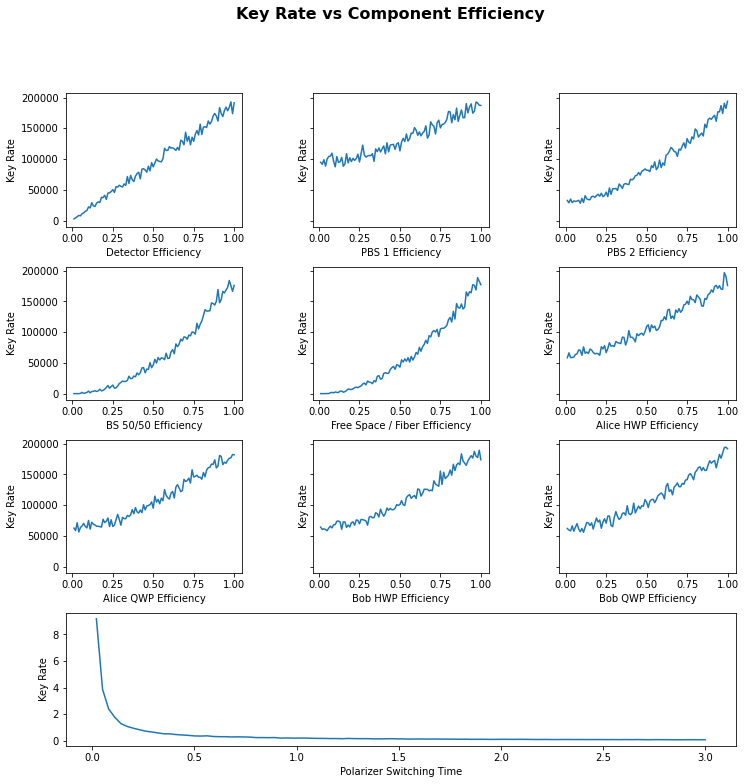

In [12]:
fig = plot_key_rate_vs_component_efficiency(NO_LOSS, save_fig=True)

TODO: 
- Characterize 3 levels of each component (cheap, average, expensive) and run through every combination of components. Plot key rate as a function of cost based on total components

In [ ]:
half_wave_plate = {
    "cheap":
    "avg":
    "state_of_the_art": 
}  # different motor speeds

detectors = {
    "cheap":
    "avg":
    "state_of_the_art": 
}


NO_LOSS = ExperimentalLoss(
    e_d = 1,      
    e_pbs1 = 1,    
    e_pbs2 = 1,   
    e_bs50 = 1,    
    e_fff = 1,
    
    e_hwp_a = 1,  
    e_qwp_a = 1, 
    e_hwp_b = 1,  
    e_qwp_b = 1,
    
    polarizer_switching_time_s = 1e-6  # photon generation rate of the detector is 10^5 photon/s,
)

## Testing

#### Same Basis

In [72]:
for alice in States:
    for bob in States:
        
        same_basis = alice.basis == bob.basis
        
        print(f"{alice.name}, {bob.name}: {same_basis}")

H, H: True
H, V: True
H, D: False
H, A: False
V, H: True
V, V: True
V, D: False
V, A: False
D, H: False
D, V: False
D, D: True
D, A: True
A, H: False
A, V: False
A, D: True
A, A: True


#### Detector Averages

In [63]:
steps = 100000


outputs = {
    "Alice": [],
    "Bob": [],
    "d1v": [],
    "d1h": [],
    "d2v": [],
    "d2h": []
}

def simulate_detector_counts(alice: States, bob: States, loss: ExperimentalLoss) -> Measurement:
    
    alice_loss = loss.e_fff * loss.e_hwp_a * loss.e_qwp_a
    bob_loss = loss.e_fff * loss.e_hwp_b * loss.e_qwp_b
    
    detector_weights = [
        loss.e_d * N1v(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs1),
        loss.e_d * N1h(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs1),
        loss.e_d * N2v(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs2),
        loss.e_d * N2h(*alice.loss_value(alice_loss), *bob.loss_value(bob_loss), loss.e_bs50, loss.e_pbs2),
    ]
    
    scale_factor = 2 / sum(detector_weights)
    scaled_detector_weights = [scale_factor * weight for weight in detector_weights]
    
    detector_hits = random.choices(["d1v", "d1h", "d2v", "d2h"], weights=scaled_detector_weights, k=2)

    is_valid = random.random() <= 1/scale_factor
    d1v = detector_hits.count("d1v") if is_valid else 0
    d1h = detector_hits.count("d1h") if is_valid else 0
    d2v = detector_hits.count("d2v") if is_valid else 0
    d2h = detector_hits.count("d2h") if is_valid else 0
    
    return d1v, d1h, d2v, d2h

    
    

def simulate_detector_count_averages(loss: ExperimentalLoss): 
    
    outputs = {
        "Alice": [],
        "Bob": [],
        "d1v": [],
        "d1h": [],
        "d2v": [],
        "d2h": []
    }
    
    
    for alice in tqdm(States, desc=f"Alice"):
        for bob in tqdm(States, desc=f"Bob", position=1):
            
            d1v = 0
            d1h = 0
            d2v = 0
            d2h = 0
            for i in tqdm(range(steps), desc=f"steps", position=2, leave=False):
                _d1v, _d1h, _d2v, _d2h = simulate_detector_counts(alice, bob, loss)
                
                d1v += _d1v
                d1h += _d1h
                d2v += _d2v
                d2h += _d2h


            outputs["Alice"].append(alice)
            outputs["Bob"].append(bob)


            outputs['d1v'].append(round(d1v/steps, 4))
            outputs['d1h'].append(round(d1h/steps, 4))
            outputs['d2v'].append(round(d2v/steps, 4))
            outputs['d2h'].append(round(d2h/steps, 4))
        
    df = pd.DataFrame(outputs)  
    df = df.set_index(["Alice", "Bob"])  
    
    return df

In [60]:
simulate_detector_count_averages(NO_LOSS)

Alice:   0%|          | 0/4 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

d1v     d1h     d2v     d2h
Alice    Bob                                     
States.H States.H  0.0000  0.0000  0.0000  2.0000
         States.V  0.4963  0.4988  0.5013  0.5036
         States.D  0.2495  0.0425  0.2529  1.4551
         States.A  0.2503  0.0430  0.2510  1.4557
States.V States.H  0.4983  0.4991  0.5005  0.5020
         States.V  0.0000  0.0000  2.0000  0.0000
         States.D  0.0419  0.2495  1.4587  0.2500
         States.A  1.4583  0.2500  0.0430  0.2487
States.D States.H  0.2500  0.0435  0.2497  1.4569
         States.V  0.0430  0.2493  1.4571  0.2506
         States.D  0.0000  0.0000  0.9993  1.0007
         States.A  0.9993  0.0000  0.0000  1.0007
States.A States.H  0.2526  0.0440  0.2489  1.4545
         States.V  1.4582  0.2496  0.0426  0.2496
         States.D  0.9991  0.0000  0.0000  1.0009
         States.A  0.0000  0.0000  1.0017  0.9983

In [61]:
simulate_detector_count_averages(MIT_OPTICS_LAB_LOSS)

Alice:   0%|          | 0/4 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

d1v     d1h     d2v     d2h
Alice    Bob                                     
States.H States.H  0.0000  0.0000  0.0000  0.0189
         States.V  0.0044  0.0051  0.0046  0.0047
         States.D  0.0023  0.0004  0.0022  0.0130
         States.A  0.0024  0.0004  0.0022  0.0129
States.V States.H  0.0043  0.0044  0.0044  0.0044
         States.V  0.0000  0.0000  0.0181  0.0000
         States.D  0.0004  0.0024  0.0140  0.0021
         States.A  0.0129  0.0023  0.0004  0.0020
States.D States.H  0.0022  0.0004  0.0022  0.0136
         States.V  0.0003  0.0021  0.0136  0.0023
         States.D  0.0000  0.0000  0.0089  0.0092
         States.A  0.0088  0.0000  0.0000  0.0084
States.A States.H  0.0023  0.0004  0.0024  0.0130
         States.V  0.0139  0.0021  0.0004  0.0024
         States.D  0.0093  0.0000  0.0000  0.0086
         States.A  0.0000  0.0000  0.0088  0.0094

In [62]:
simulate_detector_count_averages(STATE_OF_THE_ART_LOSS)

Alice:   0%|          | 0/4 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

 dBob:   0%|          | 0/4 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

steps:   0%|          | 0/100000 [00:00<?, ?it/s]

d1v     d1h     d2v     d2h
Alice    Bob                                     
States.H States.H  0.0000  0.0000  0.0000  1.9602
         States.V  0.4884  0.4913  0.4904  0.4897
         States.D  0.2433  0.0422  0.2473  1.4260
         States.A  0.2428  0.0428  0.2497  1.4248
States.V States.H  0.4908  0.4904  0.4866  0.4912
         States.V  0.0000  0.0000  1.9593  0.0000
         States.D  0.0432  0.2434  1.4291  0.2438
         States.A  1.4270  0.2453  0.0425  0.2454
States.D States.H  0.2446  0.0424  0.2422  1.4312
         States.V  0.0419  0.2472  1.4240  0.2460
         States.D  0.0000  0.0000  0.9796  0.9817
         States.A  0.9802  0.0000  0.0000  0.9808
States.A States.H  0.2425  0.0411  0.2436  1.4335
         States.V  1.4300  0.2439  0.0427  0.2430
         States.D  0.9768  0.0000  0.0000  0.9824
         States.A  0.0000  0.0000  0.9776  0.9838

#### Bits per Photon Rates

How many valid bits per photon

In [56]:
no_loss_bits_per_photon = calculate_bits_per_photon(NO_LOSS)
mit_optics_lab_bits_per_photon = calculate_bits_per_photon(MIT_OPTICS_LAB_LOSS)
state_of_the_art_bits_per_photon = calculate_bits_per_photon(STATE_OF_THE_ART_LOSS)

Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.1931
std_key_rate=0.0045
Time to run: 3.1 seconds
----------------------------------
Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.0016
std_key_rate=0.0007
Time to run: 3.01 seconds
----------------------------------
Calculating bits per photon...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_key_rate=0.1802
std_key_rate=0.0072
Time to run: 3.13 seconds
----------------------------------


#### Step Rates

Time to execute one step

In [57]:
no_loss_photon_simulation_rate = calculate_photon_simulation_rate(NO_LOSS)
mit_optics_lab_photon_simulation_rate = calculate_photon_simulation_rate(MIT_OPTICS_LAB_LOSS)
state_of_the_art_photon_simulation_rate = calculate_photon_simulation_rate(STATE_OF_THE_ART_LOSS)

Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.7e-05
std_time_per_step=2e-06
Time to run: 0.6 seconds
----------------------------------
Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.7e-05
std_time_per_step=4e-06
Time to run: 0.58 seconds
----------------------------------
Calculating photon simulation rate...


  0%|          | 0/9 [00:00<?, ?it/s]

avg_time_per_step=6.8e-05
std_time_per_step=3e-06
Time to run: 0.6 seconds
----------------------------------


#### Secret Key Rates

In [58]:
no_loss_key_rate = calculate_key_rate(NO_LOSS)
mit_optics_lab_key_rate = calculate_key_rate(MIT_OPTICS_LAB_LOSS)
state_of_the_art_key_rate = calculate_key_rate(STATE_OF_THE_ART_LOSS)

print(f"{no_loss_key_rate = } bits/second")
print(f"{mit_optics_lab_key_rate = } bits/second")
print(f"{state_of_the_art_key_rate = } bits/second")

no_loss_key_rate = 193900.0 bits/second
mit_optics_lab_key_rate = 0.0006 bits/second
state_of_the_art_key_rate = 9.29 bits/second
